In [2]:
import torch
import phate
import scprep
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle

/home/mila/g/guillaume.huguet/.conda/envs/phate_fim/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tree_data, tree_clusters = phate.tree.gen_dla(n_dim=10, n_branch=5, branch_length=30)
phate_operator = phate.PHATE(random_state=42)
tree_phate = phate_operator.fit_transform(tree_data)

Calculating PHATE...
  Running PHATE on 150 observations and 10 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculating affinities...
  Calculated graph and diffusion operator in 0.02 seconds.
  Calculating optimal t...
    Automatically selected t = 25
  Calculated optimal t in 0.06 seconds.
  Calculating diffusion potential...
  Calculating metric MDS...
  Calculated metric MDS in 0.07 seconds.
Calculated PHATE in 0.17 seconds.


(150, 10)
(150, 2)
(150,)


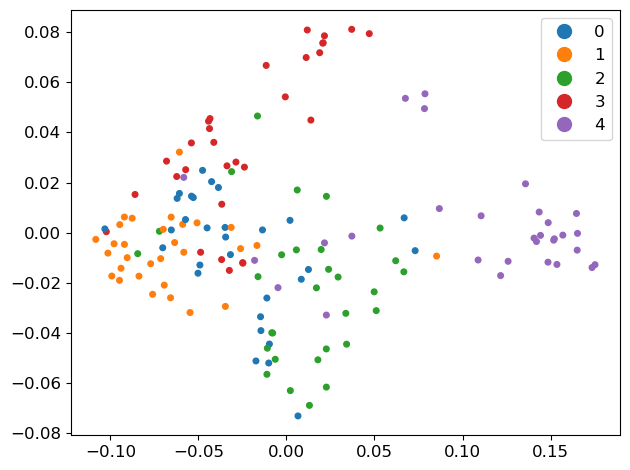

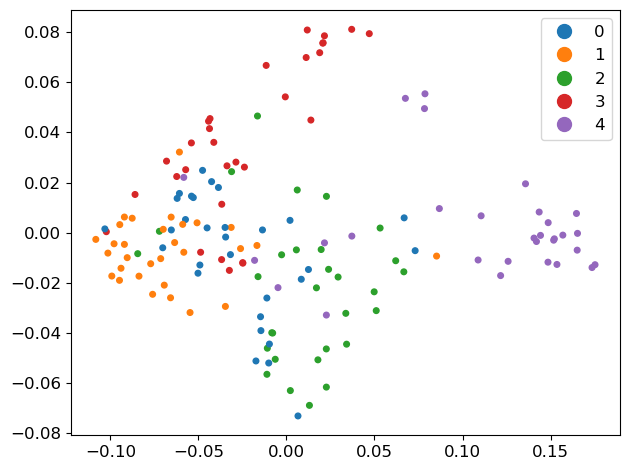

In [3]:
cax = scprep.plot.scatter2d(tree_phate, c=tree_clusters)
print(tree_data.shape)
print(tree_phate.shape)
print(tree_clusters.shape)

In [99]:
X = torch.tensor(tree_data, requires_grad=True)
n = 150
random_indices = np.random.randint(tree_data.shape[0], size=n)

In [3]:
def torch_phate(X, kernel="gaussian", bandwidth=1000, t=10):
    dists = torch.norm(X[:, None] - X, dim=2, p="fro")

    def gaussian_kernel(x):
        return torch.exp(-(dists**2) / bandwidth)

    kernel = gaussian_kernel(dists)
    p = kernel / kernel.sum(axis=0)[:, None]
    pt = torch.matrix_power(p, t)
    # log_p = torch.log(pt)
    return pt

In [101]:
P = torch_phate(X[random_indices])
J = torch.autograd.functional.jacobian(torch_phate, X[random_indices])
# shape: N_output [N x N], input [N x D]

Jt = J.transpose(1, 2)

fischer_information = torch.sum(J * Jt * P[:, :, None, None], dim=1)
fischer_information_flat = fischer_information.reshape(n, -1)

In [112]:
fischer_information.shape, J.shape

(torch.Size([150, 150, 10]), torch.Size([150, 150, 150, 10]))

# FIM new try

FIM only for the first observation with a dataset of size 15.

In [88]:
# J[i][j] is Jacobian of the ith output w.r.t. to j-th input. We only need the "diagonal".
jac = torch.empty((15, 15, 10))
for i in range(15):
    jac[i] = J[i][i]
# Use the first one for example
jac1 = jac[0]

# Element wise product over the observations i.e. we are multiplying vectors of size n_obs. weighted by the prob.
prod = torch.ones((10, 10, 15))
for i in range(10):
    for j in range(10):
        prod[i][j] = jac1[:, i] * jac1[:, j] * torch.exp(P[0, :])

# Taking the average of the observations
fim = torch.mean(prod, dim=2)

For all observations (todo write something more efficient)

In [110]:
# For all observations
n_obs, n_dim = X.shape
jac = torch.empty((n_obs, n_obs, n_dim))
for i in range(n_obs):
    jac[i] = J[i][i]
prod = torch.ones((n_obs, n_dim, n_dim, n_obs))
for i in range(n_dim):
    for j in range(n_dim):
        prod[:, i, j, :] = jac[:, :, i] * jac[:, :, j] * torch.exp(P)
# Taking the average of the observations
fim = torch.mean(prod, dim=3)

In [126]:
torch.any(prod == 1), fim.shape

(tensor(False), torch.Size([150, 10, 10]))

Volume for each points

In [115]:
# Compute Volume
V = np.sqrt(np.linalg.det(fim.detach().cpu()))

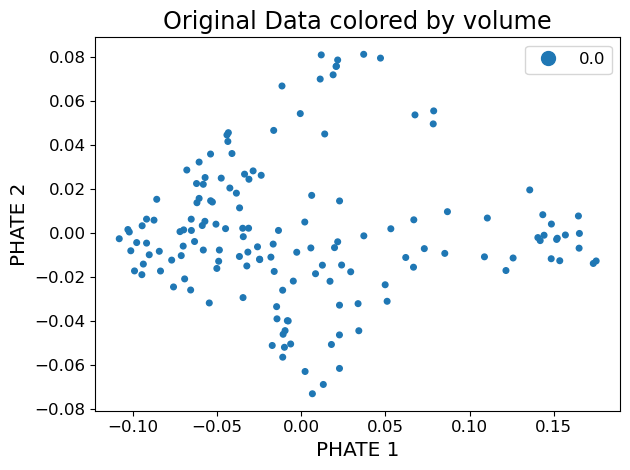

In [127]:
# Visualize Original PHATE data with volume measurement
# Visualize ground truth
cax = scprep.plot.scatter2d(
    tree_phate,
    c=V,
    title="Original Data colored by volume",
    xlabel="PHATE 1",
    ylabel="PHATE 2",
)

# same on the sphere

(1000, 10)


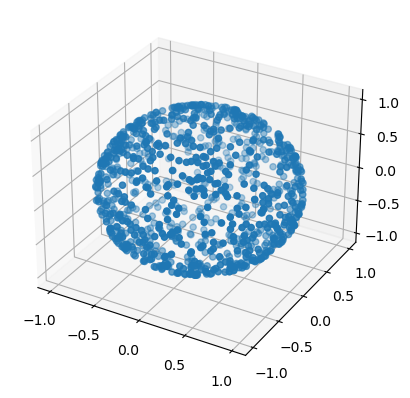

In [6]:
sphere = []
for i in range(1000):
    x = np.random.normal(0,1,3)
    sphere.append(x/(np.sqrt(np.sum(x**2))))
   
nsphere = np.array(sphere)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(nsphere[:,0], nsphere[:,1], nsphere[:,2])

zerovec = np.zeros((1000,7))

highdsphere = np.concatenate((nsphere,zerovec),axis=1)
print(highdsphere.shape)

In [9]:
#Run PHATE on sphere

phate_operator = phate.PHATE(random_state=42)
X = phate_operator.fit_transform(highdsphere)

Calculating PHATE...
  Running PHATE on 1000 observations and 10 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculating affinities...
  Calculated graph and diffusion operator in 0.02 seconds.
  Calculating optimal t...
    Automatically selected t = 23
  Calculated optimal t in 0.42 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.33 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.59 seconds.
Calculated PHATE in 1.38 seconds.


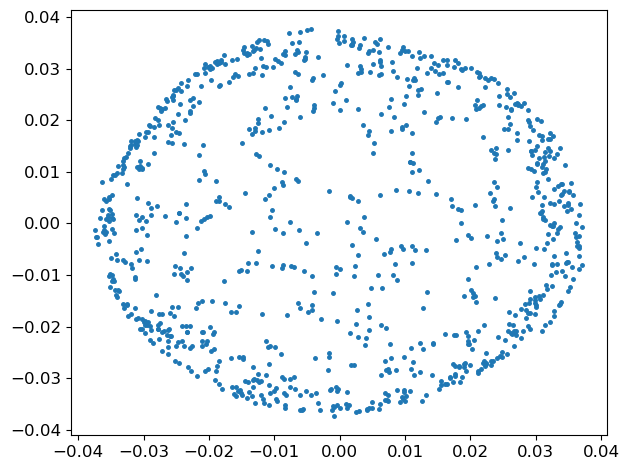

In [10]:
#Visualize high dimensional sphere with PHATE

cax = scprep.plot.scatter2d(phate_sphere)

Generate high dimension sphere with Muller's method.

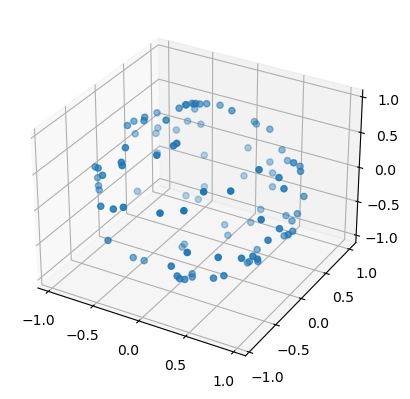

In [32]:
N = 100
dim = 3

norm = np.random.normal
normal_deviates = norm(size=(dim, N))

radius = np.sqrt((normal_deviates**2).sum(axis=0))
X = (normal_deviates/radius).T

if dim ==3:
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(X[:,0], X[:,1], X[:,2])

In [33]:
X = torch.Tensor(X)
P = torch_phate(X)
J = torch.autograd.functional.jacobian(torch_phate, X)

In [34]:
# For all observations
n_obs, n_dim = X.shape
jac = torch.empty((n_obs, n_obs, n_dim))
for i in range(n_obs):
    jac[i] = J[i][i]
prod = torch.ones((n_obs, n_dim, n_dim, n_obs))
for i in range(n_dim):
    for j in range(n_dim):
        prod[:, i, j, :] = jac[:, :, i] * jac[:, :, j] * torch.exp(P)
# Taking the average of the observations
fim = torch.mean(prod, dim=3)

Calculating PHATE...
  Running PHATE on 100 observations and 3 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculating affinities...
  Calculating optimal t...
    Automatically selected t = 30
  Calculating diffusion potential...
  Calculating metric MDS...
  Calculated metric MDS in 0.02 seconds.
Calculated PHATE in 0.07 seconds.


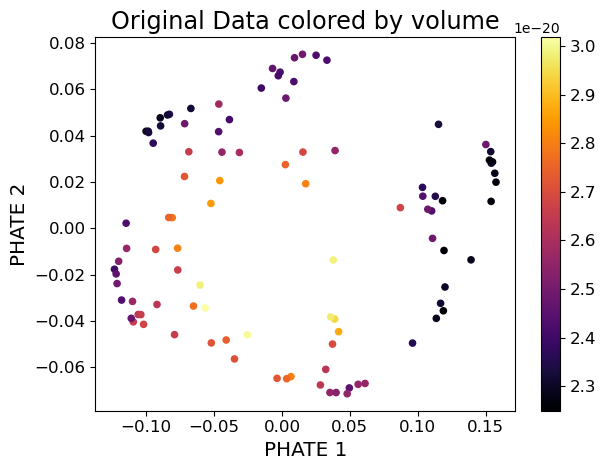

In [35]:
# Compute Volume
V = np.sqrt(np.linalg.det(fim.detach().cpu()))

#Run PHATE on sphere
phate_operator = phate.PHATE(random_state=42)
phate_sphere = phate_operator.fit_transform(X)

# Visualize Original PHATE data with volume measurement
# Visualize ground truth
cax = scprep.plot.scatter2d(
    phate_sphere,
    c=V,
    title="Original Data colored by volume",
    xlabel="PHATE 1",
    ylabel="PHATE 2",
)

in 5 D

Calculating PHATE...
  Running PHATE on 100 observations and 5 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculating affinities...
  Calculating optimal t...
    Automatically selected t = 46
  Calculating diffusion potential...
  Calculating metric MDS...
Calculated PHATE in 0.03 seconds.


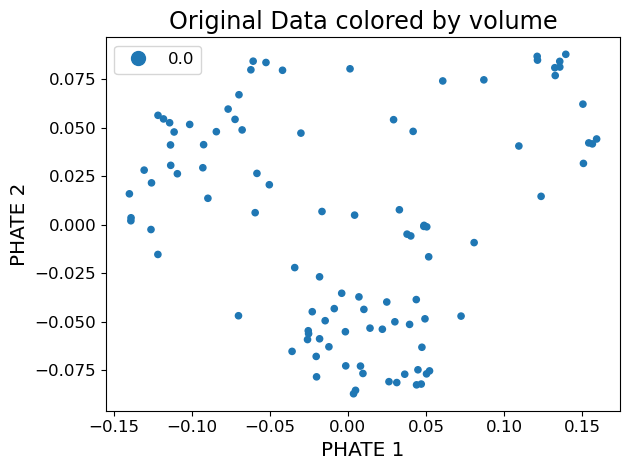

In [36]:
N = 100
dim = 5

norm = np.random.normal
normal_deviates = norm(size=(dim, N))

radius = np.sqrt((normal_deviates**2).sum(axis=0))
X = (normal_deviates/radius).T

X = torch.Tensor(X)
P = torch_phate(X)
J = torch.autograd.functional.jacobian(torch_phate, X)

# For all observations
n_obs, n_dim = X.shape
jac = torch.empty((n_obs, n_obs, n_dim))
for i in range(n_obs):
    jac[i] = J[i][i]
prod = torch.ones((n_obs, n_dim, n_dim, n_obs))
for i in range(n_dim):
    for j in range(n_dim):
        prod[:, i, j, :] = jac[:, :, i] * jac[:, :, j] * torch.exp(P)
# Taking the average of the observations
fim = torch.mean(prod, dim=3)

# Compute Volume
V = np.sqrt(np.linalg.det(fim.detach().cpu()))

#Run PHATE on sphere
phate_operator = phate.PHATE(random_state=42)
phate_sphere = phate_operator.fit_transform(X)

# Visualize Original PHATE data with volume measurement
# Visualize ground truth
cax = scprep.plot.scatter2d(
    phate_sphere,
    c=V,
    title="Original Data colored by volume",
    xlabel="PHATE 1",
    ylabel="PHATE 2",
)
